# CIFAR analysis

In [1]:
import pickle


import tensorflow as tf
from tensorflow.python import  keras
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPool2D
from tensorflow.python.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import sys


import cv2
from sklearn import svm
from sklearn.model_selection import train_test_split

## Unpickling data

In [2]:
with open("../cifar-10-batches-py/data_batch_1","rb") as infile:
    cifar = pickle.load(infile, encoding="bytes")
    
names = np.asarray(cifar[b'filenames'])

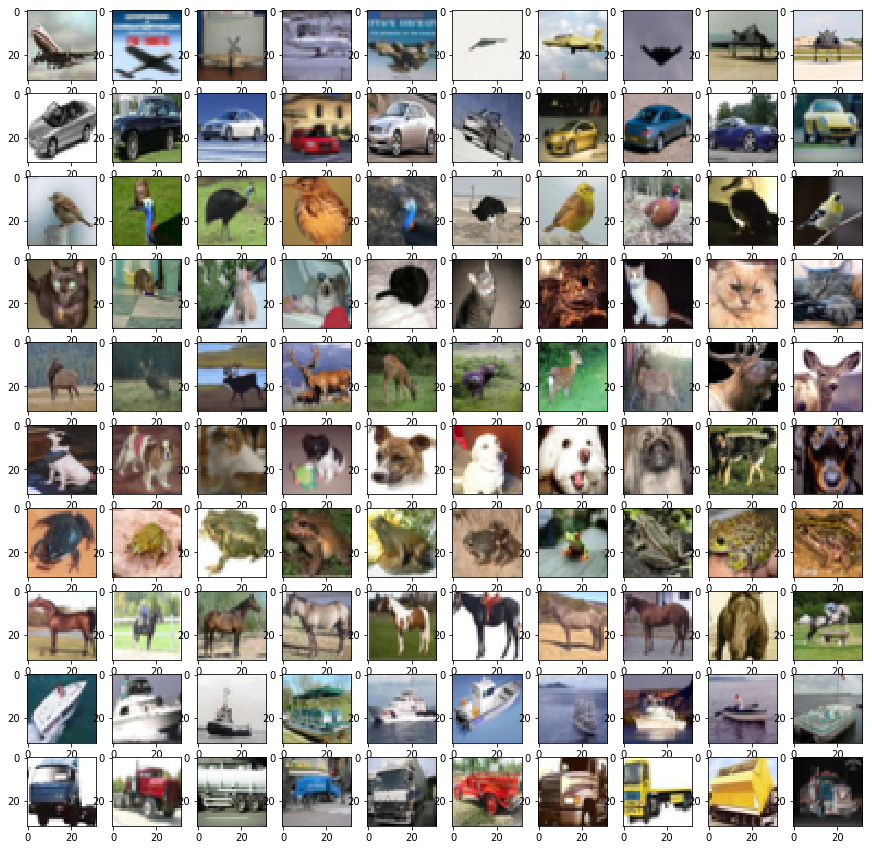

In [3]:
X_train,  X_test, y_train, y_test = train_test_split(cifar[b'data'],cifar[b'labels'],test_size=0.2)

random_indices = []
for idx in range(10):
    random_indices += list(np.random.choice(np.where(np.array(y_train)==idx)[0], size=10))

fig = plt.figure(figsize=(15,15))
for i, ridx in enumerate(random_indices):
    fig.add_subplot(10,10,i+1)

    tmp_picture = X_train[ridx,:].reshape(3,32,32).transpose([1, 2, 0])
    plt.imshow(tmp_picture)
plt.show()

## Shallow clasifier

In [4]:
winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [5]:
X_train_HOG = X_train.reshape(-1,3,32,32).transpose([0,2, 3, 1])
train_descriptors = np.zeros((X_train.shape[0], 324))

for idx, X_example in enumerate(X_train_HOG):
    descriptor = hog.compute(X_example)
    train_descriptors[idx,:] = descriptor.ravel()

In [6]:
shallow_classifier = svm.LinearSVC()
shallow_classifier.fit(train_descriptors, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [7]:
X_test_HOG = X_test.reshape(-1,3,32,32).transpose([0,2, 3, 1])
test_descriptors = np.zeros((X_test.shape[0], 324))

for idx, X_example in enumerate(X_test_HOG):
    descriptor = hog.compute(X_example)
    test_descriptors[idx,:] = descriptor.ravel()

In [8]:
shallow_predict = shallow_classifier.predict(test_descriptors)

In [9]:
np.mean(shallow_predict==y_test)

0.5145

## Pretrained neural network

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')

In [11]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
model_codes = keras.backend.function([model.layers[0].input],
                                          [model.layers[21].output])


In [13]:
X_train_cnn = np.zeros((X_train.shape[0],224,224,3)) 
X_train_cnn[:,:32,:32,:] = X_train.reshape(-1,3,32,32).transpose([0,2, 3, 1])

In [ ]:

codes_train = model_codes([X_train_cnn])